In [5]:
from longeval.spark import get_spark
from pyspark.sql import functions as F

spark = get_spark(cores=4)
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
spark

25/02/13 03:37:15 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [6]:
df = spark.read.json(
    "/storage/home/hcoda1/8/amiyaguchi3/clef/longeval-2025/nvidia-logs-1739431274.ndjson"
)
df.printSchema()

root
 |-- nvidia_smi_log: struct (nullable = true)
 |    |-- attached_gpus: string (nullable = true)
 |    |-- cuda_version: string (nullable = true)
 |    |-- driver_version: string (nullable = true)
 |    |-- gpu: struct (nullable = true)
 |    |    |-- @id: string (nullable = true)
 |    |    |-- accounted_processes: string (nullable = true)
 |    |    |-- accounting_mode: string (nullable = true)
 |    |    |-- accounting_mode_buffer_size: string (nullable = true)
 |    |    |-- addressing_mode: string (nullable = true)
 |    |    |-- applications_clocks: struct (nullable = true)
 |    |    |    |-- graphics_clock: string (nullable = true)
 |    |    |    |-- mem_clock: string (nullable = true)
 |    |    |-- bar1_memory_usage: struct (nullable = true)
 |    |    |    |-- free: string (nullable = true)
 |    |    |    |-- total: string (nullable = true)
 |    |    |    |-- used: string (nullable = true)
 |    |    |-- board_id: string (nullable = true)
 |    |    |-- board_part_num

In [7]:
sub = df.select(
    F.unix_timestamp("nvidia_smi_log.timestamp", "EEE MMM dd HH:mm:ss yyyy").alias(
        "timestamp"
    ),
    "nvidia_smi_log.gpu.product_name",
    "nvidia_smi_log.gpu.utilization",
    "nvidia_smi_log.gpu.processes.process_info",
).orderBy(F.desc("timestamp"))
sub.printSchema()
sub.where("process_info is not null").show(vertical=True, n=5, truncate=100)

root
 |-- timestamp: long (nullable = true)
 |-- product_name: string (nullable = true)
 |-- utilization: struct (nullable = true)
 |    |-- decoder_util: string (nullable = true)
 |    |-- encoder_util: string (nullable = true)
 |    |-- gpu_util: string (nullable = true)
 |    |-- jpeg_util: string (nullable = true)
 |    |-- memory_util: string (nullable = true)
 |    |-- ofa_util: string (nullable = true)
 |-- process_info: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- compute_instance_id: string (nullable = true)
 |    |    |-- gpu_instance_id: string (nullable = true)
 |    |    |-- pid: string (nullable = true)
 |    |    |-- process_name: string (nullable = true)
 |    |    |-- type: string (nullable = true)
 |    |    |-- used_memory: string (nullable = true)

-RECORD 0------------------------------------------------------------------------------------------------------------
 timestamp    | 1739431731                                   

In [8]:
# parse a unix timestamp from Thu Feb 13 02:28:51 2025
# timestamp = F.to_unix_timestamp("Thu Feb 13 02:28:51 2025", "EEE MMM dd HH:mm:ss yyyy")

In [9]:
all_times = sub.select("timestamp").distinct().orderBy("timestamp")
exploded = (
    sub.select(
        "timestamp",
        F.explode_outer("process_info").alias("process"),
    )
    .select(
        "timestamp",
        "process.*",
    )
    .drop("compute_instance_id", "gpu_instance_id", "type")
)
exploded.printSchema()
exploded.show()

root
 |-- timestamp: long (nullable = true)
 |-- pid: string (nullable = true)
 |-- process_name: string (nullable = true)
 |-- used_memory: string (nullable = true)



+----------+-------+--------------------+-----------+
| timestamp|    pid|        process_name|used_memory|
+----------+-------+--------------------+-----------+
|1739431822|   NULL|                NULL|       NULL|
|1739431807|   NULL|                NULL|       NULL|
|1739431792|   NULL|                NULL|       NULL|
|1739431776|   NULL|                NULL|       NULL|
|1739431761|   NULL|                NULL|       NULL|
|1739431746|   NULL|                NULL|       NULL|
|1739431731|2973972|/storage/scratch1...|    482 MiB|
|1739431731|2973976|/storage/scratch1...|    482 MiB|
|1739431715|2973972|/storage/scratch1...|    482 MiB|
|1739431715|2973976|/storage/scratch1...|    482 MiB|
|1739431700|2973972|/storage/scratch1...|    482 MiB|
|1739431700|2973976|/storage/scratch1...|    482 MiB|
|1739431685|2973972|/storage/scratch1...|    482 MiB|
|1739431685|2973976|/storage/scratch1...|    482 MiB|
|1739431670|2973972|/storage/scratch1...|    482 MiB|
|1739431670|2973976|/storage

In [10]:
# generate a single array to get process per name
process_memory = exploded.groupBy("pid", "process_name").agg(
    # collect ordered by timestamp
    F.collect_list(F.struct("timestamp", "used_memory")).alias("used_memory"),
)
process_memory.show()
mem = process_memory.collect()
mem

+-------+--------------------+--------------------+
|    pid|        process_name|         used_memory|
+-------+--------------------+--------------------+
|2973976|/storage/scratch1...|[{1739431731, 482...|
|   NULL|                NULL|[{1739431822, NUL...|
|2973972|/storage/scratch1...|[{1739431731, 482...|
+-------+--------------------+--------------------+



[Row(pid='2973976', process_name='/storage/scratch1/8/amiyaguchi3/longeval/.venv/bin/python3', used_memory=[Row(timestamp=1739431731, used_memory='482 MiB'), Row(timestamp=1739431715, used_memory='482 MiB'), Row(timestamp=1739431700, used_memory='482 MiB'), Row(timestamp=1739431685, used_memory='482 MiB'), Row(timestamp=1739431670, used_memory='482 MiB'), Row(timestamp=1739431655, used_memory='482 MiB'), Row(timestamp=1739431639, used_memory='482 MiB'), Row(timestamp=1739431624, used_memory='482 MiB'), Row(timestamp=1739431609, used_memory='482 MiB')]),
 Row(pid=None, process_name=None, used_memory=[Row(timestamp=1739431822, used_memory=None), Row(timestamp=1739431807, used_memory=None), Row(timestamp=1739431792, used_memory=None), Row(timestamp=1739431776, used_memory=None), Row(timestamp=1739431761, used_memory=None), Row(timestamp=1739431746, used_memory=None), Row(timestamp=1739431594, used_memory=None), Row(timestamp=1739431578, used_memory=None), Row(timestamp=1739431563, used_me

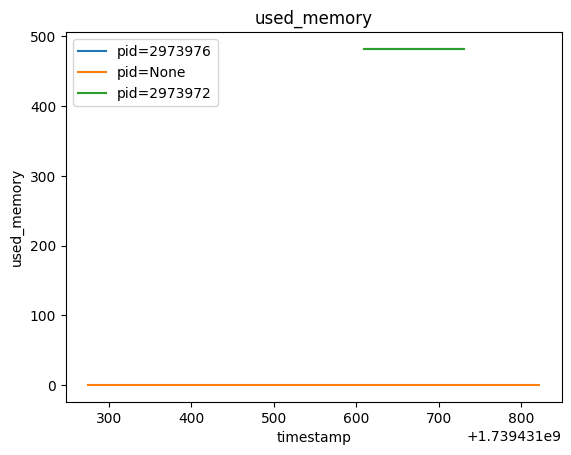

In [11]:
from matplotlib import pyplot as plt

plt.figure()
plt.xlabel("timestamp")
plt.ylabel("used_memory")
plt.title("used_memory")
ax = plt.gca()
for row in mem:
    x = [r.timestamp for r in row.used_memory]
    y = [int((r.used_memory or "0").split()[0]) for r in row.used_memory]
    ax.plot(x, y, label=f"pid={row.pid}")
plt.legend()
plt.show()

+----------+--------+-----------+
| timestamp|gpu_util|memory_util|
+----------+--------+-----------+
|1739431609|      25|          2|
|1739431624|      36|          3|
|1739431639|      36|          3|
|1739431655|      31|          3|
|1739431670|      10|          1|
|1739431685|      20|          2|
|1739431700|      31|          3|
|1739431715|      31|          3|
|1739431731|      37|          3|
+----------+--------+-----------+



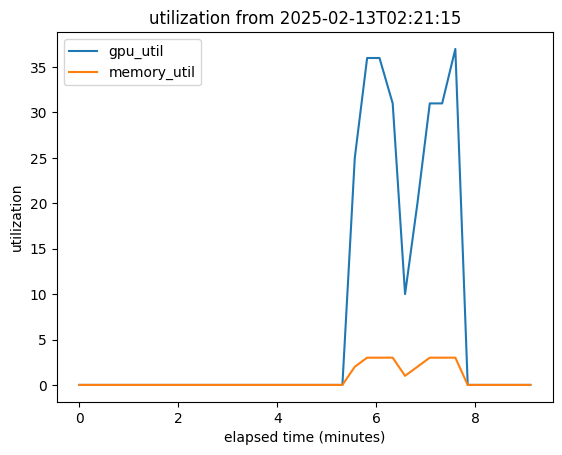

In [ ]:
from datetime import datetime

# sub.printSchema()
util = sub.select(
    "timestamp",
    F.split("utilization.gpu_util", " ")[0].cast("int").alias("gpu_util"),
    F.split("utilization.memory_util", " ")[0].cast("int").alias("memory_util"),
).orderBy("timestamp")
util.where("gpu_util <> 0").show()

utilpd = util.toPandas()

# convert unix timestamp to an actual date
ds = datetime.fromtimestamp(utilpd["timestamp"].min()).isoformat()
plt.figure()
plt.xlabel("elapsed time (minutes)")
plt.ylabel("utilization")
plt.title(f"GPU utilization from {ds}")
ax = plt.gca()
ts = (utilpd["timestamp"] - utilpd["timestamp"].min()) / 60
ax.plot(ts, utilpd.gpu_util, label="gpu_util")
ax.plot(ts, utilpd.memory_util, label="memory_util")
plt.legend()
plt.show()